[Money Creation Examples](http://www.siebenbrunner.com/moneycreation/) > **Example 3**:
# Payments and bank refinancing
This notebook presents several standard transactions for banks, how they are represented as booking statements, and their implications for the money supply. In particular we consider:

- Deposit transfers (within a bank and between customers of different banks)
- Cash withdrawals
- Interbank lending
- Wholesale Funding
- Central Bank Funding

We start by importing required utilities:

In [1]:
import os
import sys

base_path = os.path.realpath(os.getcwd()+"/../..")
sys.path.append(base_path)

from abcFinance import Ledger, Account, AccountSide

We further define a function that computes the money stocks according to our defined taxonomy:

In [2]:
from IPython.core.display import SVG
from IPython.display import display_svg

def print_money_stocks():
    # Bank money: bank liabilities that are money
    bank_money = bank1.get_balance('Deposits Customer A')[1]
    bank_money += bank1.get_balance('Deposits Customer B')[1]
    bank_money += bank2.get_balance('Deposits Customer C')[1]
    
    central_bank_money = private_agentA.get_balance('Cash')[1]
    central_bank_money += private_agentB.get_balance('Cash')[1]
    central_bank_money += private_agentC.get_balance('Cash')[1]
    
    print("Commercial Bank Money:",bank_money)
    if central_bank_money>0:
        print("Central Bank Money:",central_bank_money)
    print("Total (Bank) Money:",bank_money+central_bank_money)

def print_balance_sheets_and_money_stocks(*args):
    private_agentA.book_end_of_period()
    private_agentB.book_end_of_period()
    private_agentC.book_end_of_period()
    
    if len(args)==0:
        args = ("b1","b2","pA","pB","pC","cb")
    if "b1" in args and bank1.get_total_assets() > 0: display_svg(SVG(bank1.draw_balance_sheet("Bank 1 Balance Sheet", width=400)))
    if "b2" in args and bank2.get_total_assets() > 0: display_svg(SVG(bank2.draw_balance_sheet("Bank 2 Balance Sheet", width=400)))
    if "pA" in args and private_agentA.get_total_assets() > 0: display_svg(SVG(private_agentA.draw_balance_sheet("Private Agent A Balance Sheet", width=400)))
    if "pB" in args and private_agentB.get_total_assets() > 0: display_svg(SVG(private_agentB.draw_balance_sheet("Private Agent B Balance Sheet", width=400)))
    if "pC" in args and private_agentC.get_total_assets() > 0: display_svg(SVG(private_agentC.draw_balance_sheet("Private Agent C Balance Sheet", width=400)))
    if "cb" in args and central_bank.get_total_assets() > 0: display_svg(SVG(central_bank.draw_balance_sheet("Central Bank Balance Sheet", width=400)))
        
    print_money_stocks()

## Declaration of agents
We define a system with one central bank, two commercial banks and three private sector agents.

In [3]:
bank1 = Ledger(residual_account_name="Equity")
bank2 = Ledger(residual_account_name="Equity")
private_agentA = Ledger(residual_account_name="Equity")
private_agentB = Ledger(residual_account_name="Equity")
private_agentC = Ledger(residual_account_name="Equity")
central_bank = Ledger(residual_account_name="Equity")

bank1.make_asset_accounts(['Cash','Loans','Reserves'])
bank1.make_liability_accounts(['Deposits Customer A','Deposits Customer B','Interbank Deposits', 'Issued Bonds', 'Central Bank Funding'])
bank2.make_asset_accounts(['Cash','Loans','Reserves','Interbank Loans'])
bank2.make_liability_accounts(['Deposits Customer C'])

private_agentA.make_asset_accounts(['Cash','Deposits'])
private_agentA.make_liability_accounts(['Loans'])
private_agentA.make_flow_accounts(['Income','Expenses'])
private_agentB.make_asset_accounts(['Cash','Deposits'])
private_agentB.make_liability_accounts(['Loans'])
private_agentB.make_flow_accounts(['Income','Expenses'])
private_agentC.make_asset_accounts(['Cash','Deposits','Bond Holdings'])
private_agentC.make_liability_accounts(['Loans'])
private_agentC.make_flow_accounts(['Income','Expenses'])

central_bank.make_asset_accounts(['Assets','Loans to Banks'])
central_bank.make_liability_accounts(['Cash','Reserves'])

## Initialization
We start by endowing each of the agents with some money holdings. The balance sheets of the agents will evolve over the course of the different examples.

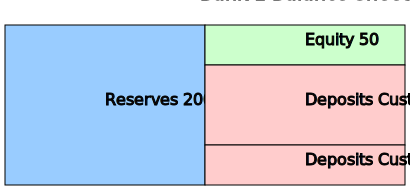

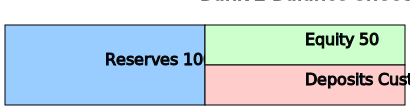

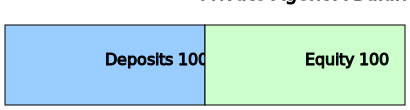

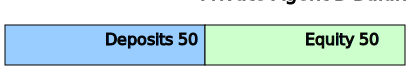

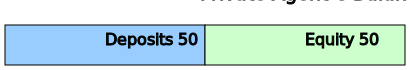

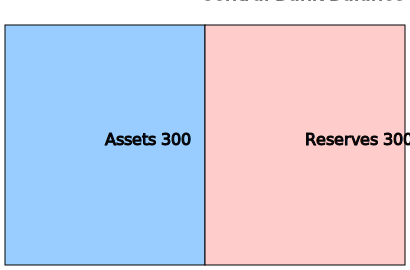

Commercial Bank Money: 200
Total (Bank) Money: 200


In [4]:
bank1.book(debit=[('Reserves',200)],credit=[('Equity',50),('Deposits Customer A',100),('Deposits Customer B',50)])
private_agentA.book(debit=[('Deposits',100)],credit=[('Equity',100)])
private_agentB.book(debit=[('Deposits',50)],credit=[('Equity',50)])
bank2.book(debit=[('Reserves',100)],credit=[('Equity',50),('Deposits Customer C',50)])
private_agentC.book(debit=[('Deposits',50)],credit=[('Equity',50)])
central_bank.book(debit=[('Assets',300)],credit=[('Reserves',300)])
print_balance_sheets_and_money_stocks()

## Deposit transfer within a bank
We start with what can arguable be considered the most simple transaction: a transfer of money between two private sector agents who are customers of the same bank. This amounts only to a change in the owners of the liabilities of that bank, with no effects on money stocks or other agents.

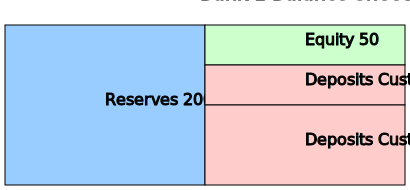

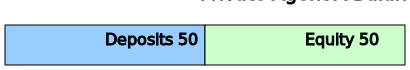

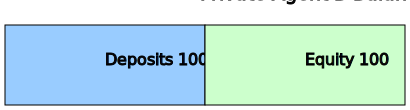

Commercial Bank Money: 200
Total (Bank) Money: 200


In [5]:
private_agentA.book(debit=[('Expenses',50)],credit=[('Deposits',50)])
private_agentB.book(debit=[('Deposits',50)],credit=[('Income',50)])
bank1.book(debit=[('Deposits Customer A',50)],credit=[('Deposits Customer B',50)])
print_balance_sheets_and_money_stocks("b1", "pA", "pB")

## Deposit transfer to another bank
We now consider the case where a depositor of Bank 1 wants to make a payment to a depositor of Bank 2. In practice, private sector agents are rarely concerned with whether their payee's account is at the same or at a different bank. For the banks involved, it makes a big difference, however. As we see, the transfer amounts to a transfer of central bank reserves between banks. These act as a form of payment for banks, the transfer has no impact on money stocks, though.

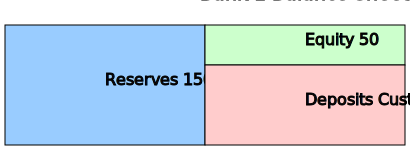

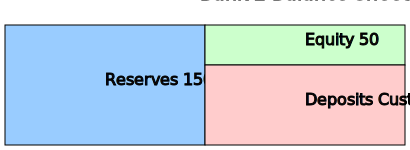

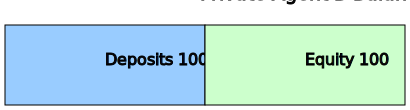

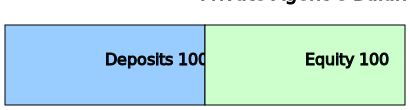

Commercial Bank Money: 200
Total (Bank) Money: 200


In [6]:
private_agentA.book(debit=[('Expenses',50)],credit=[('Deposits',50)])
private_agentC.book(debit=[('Deposits',50)],credit=[('Income',50)])
bank1.book(debit=[('Deposits Customer A',50)],credit=[('Reserves',50)])
bank2.book(debit=[('Reserves',50)],credit=[('Deposits Customer C',50)])
print_balance_sheets_and_money_stocks("pB", "pC", "b1", "b2")

## Cash withdrawal
If a customer wishes to withdraw cash, this amounts to a reduction of commercial bank money and a corresponding increase in central bank money. In this example, Bank 1 has no cash holdings yet, hence it has to convert some of its central bank reserves to cash. In practice, banks do hold some quantities of physical cash to meet such redemption demands. Since neither reserves nor cash holdings by banks are counted towards the money stock, the implications for total money stocks are the same.

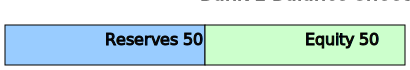

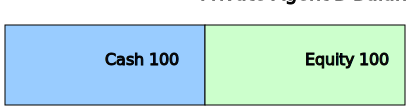

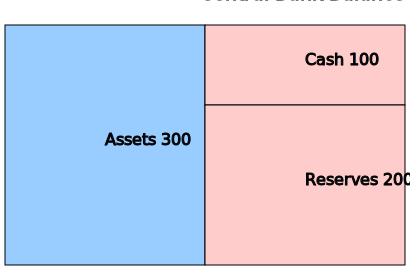

Commercial Bank Money: 100
Central Bank Money: 100
Total (Bank) Money: 200


In [7]:
private_agentB.book(debit=[('Cash',100)],credit=[('Deposits',100)])
bank1.book(debit=[('Cash',100)],credit=[('Reserves',100)])
bank1.book(debit=[('Deposits Customer B',100)],credit=[('Cash',100)])
central_bank.book(debit=[('Reserves',100)],credit=[('Cash',100)])
print_balance_sheets_and_money_stocks("pB", "b1", "cb")

## Refinancing of deposit outflows on the interbank market
As we have seen before, a payment between two customers of different banks amounts to a deposit outflow for one bank. If the bank does not have sufficient reserves to make this transaction, it needs to raise additional financing, as we will demonstrate here. We start by creating a deposit at Bank 1 through the granting of a loan.

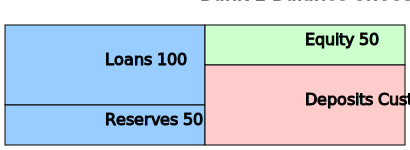

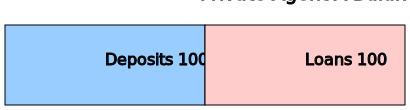

Commercial Bank Money: 200
Central Bank Money: 100
Total (Bank) Money: 300


In [8]:
bank1.book(debit=[('Loans',100)],credit=[('Deposits Customer A',100)])
private_agentA.book(debit=[('Deposits',100)],credit=[('Loans',100)])
print_balance_sheets_and_money_stocks("pA", "b1")

Private sector agent A now informs its bank (Bank 1) that it wishes to transfer its deposits to agent C, a client of Bank 2. Since Bank 1 does not have sufficient reserves to meet this deposit outflow, it first asks Bank 2 for an interbank loan, increasing its stock of reserves:

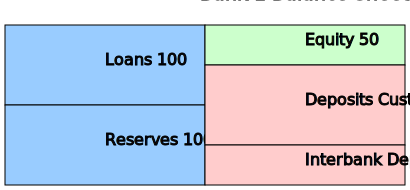

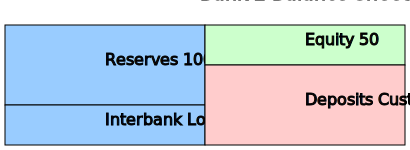

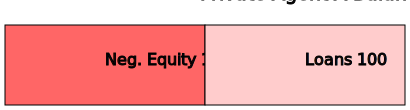

Commercial Bank Money: 200
Central Bank Money: 100
Total (Bank) Money: 300


In [9]:
private_agentA.book(debit=[('Expenses',100)],credit=[('Deposits',100)])
bank1.book(debit=[('Reserves',50)],credit=[('Interbank Deposits',50)])
bank2.book(debit=[('Interbank Loans',50)],credit=[('Reserves',50)])
print_balance_sheets_and_money_stocks("pA", "b1", "b2")

Using the additional reserves, Bank 1 can now make the transfer. We note that the transaction leaves agent A with negative equity. We will consider the implications of this further in [Example 4](http://www.siebenbrunner.com/moneycreation/Ex4_Crises.html), where we discuss banking crises. For here we only note that as long as Bank 1 does not make an impairment on its loan to private sector agent A, it is still considered as solvent.

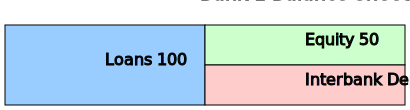

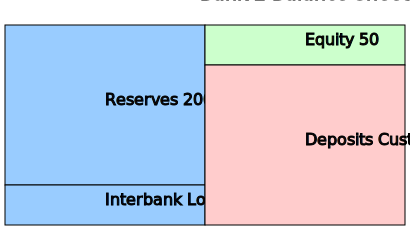

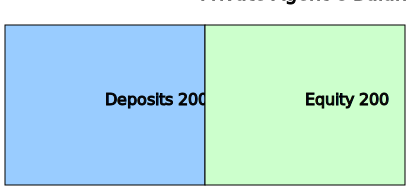

Commercial Bank Money: 200
Central Bank Money: 100
Total (Bank) Money: 300


In [10]:
bank1.book(debit=[('Deposits Customer A',100)],credit=[('Reserves',100)])
bank2.book(debit=[('Reserves',100)],credit=[('Deposits Customer C',100)])
private_agentC.book(debit=[('Deposits',100)],credit=[('Income',100)])
print_balance_sheets_and_money_stocks("pC", "b1", "b2")

Note that the entire transfer of deposits leaves all money stocks unchanged (the increase in commercial bank money at the beginning of the example was due to the granting of the loan, something we have already observed in [Example 2](http://www.siebenbrunner.com/moneycreation/Ex2_Lending.html)).

### Refinancing on wholesale markets (bank bonds purchased by private sector agents)
Suppose that Bank 1 now needs to repay the interbank loan that it has received from Bank 2 (we assume that the interest rate on the loan was 0 for simplicity - see [Example 2](http://www.siebenbrunner.com/moneycreation/Ex2_Lending.html) for an example of how interest payments are booked). In order to refinance this repayment, it first issues a bond that is purchased by private sector agent C.

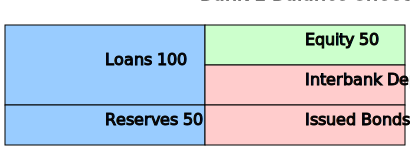

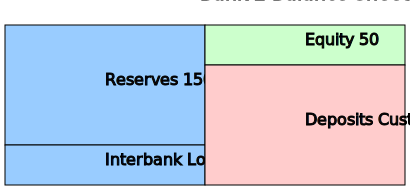

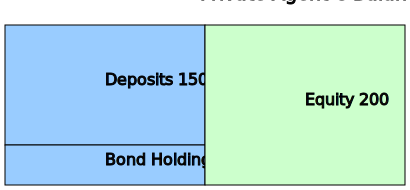

Commercial Bank Money: 150
Central Bank Money: 100
Total (Bank) Money: 250


In [11]:
private_agentC.book(debit=[('Bond Holdings',50)],credit=[('Deposits',50)])
bank2.book(debit=[('Deposits Customer C',50)],credit=[('Reserves',50)])
bank1.book(debit=[('Reserves',50)],credit=[('Issued Bonds',50)])
print_balance_sheets_and_money_stocks("pC", "b1", "b2")

Notice how the purchase of the bond reduces the stock of commercial bank money. The newly issued bond now allows Bank 1 to repay Bank 2:

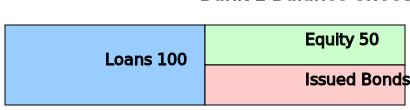

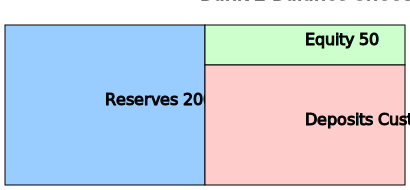

Commercial Bank Money: 150
Central Bank Money: 100
Total (Bank) Money: 250


In [12]:
bank1.book(debit=[('Interbank Deposits',50)],credit=[('Reserves',50)])
bank2.book(debit=[('Reserves',50)],credit=[('Interbank Loans',50)])
print_balance_sheets_and_money_stocks("b1", "b2")

### Refinancing via the Central Bank
Now we assume that Bank A needs to repay its bond (for simplicity, we again assume that the interest rate was zero). If neither Bank 2 nor any private sector agents are able or willing to finance Bank 1 either through interbank loans or bond purchases, then Bank 1 has only one recourse left: going to the central bank.

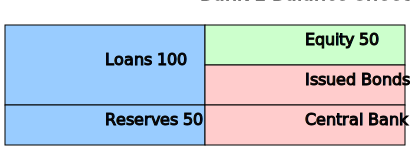

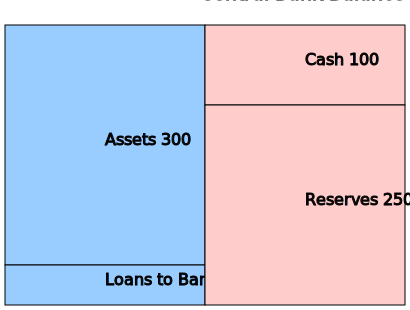

Commercial Bank Money: 150
Central Bank Money: 100
Total (Bank) Money: 250


In [13]:
bank1.book(debit=[('Reserves',50)],credit=[('Central Bank Funding',50)])
central_bank.book(debit=[('Loans to Banks',50)],credit=[('Reserves',50)])
print_balance_sheets_and_money_stocks("b1", "cb")

The new funding from the central bank now allows Bank 1 to pay back its bond liabilities. Note how the repayment increases the money stock again that was first decreased through the sale of the bond.

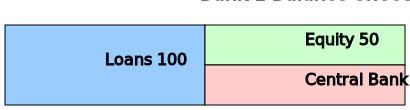

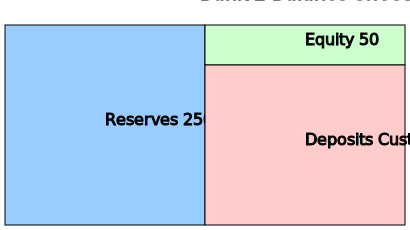

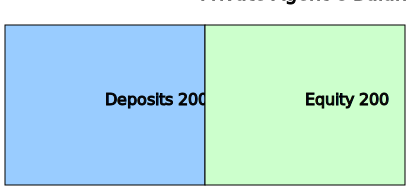

Commercial Bank Money: 200
Central Bank Money: 100
Total (Bank) Money: 300


In [14]:
bank1.book(debit=[('Issued Bonds',50)],credit=[('Reserves',50)])
bank2.book(debit=[('Reserves',50)],credit=[('Deposits Customer C',50)])
private_agentC.book(debit=[('Deposits',50)],credit=[('Bond Holdings',50)])
print_balance_sheets_and_money_stocks("b1", "b2", "pC")

Note that Bank 1 was dependent on the central bank for funding to refinance its bond repayment. If the central bank had refused this transaction Bank 1 would have failed due to illiquidity, even though it is still solvent (considering that it has not yet made an impairment on its loan to private agent A), a topic that we will discuss further in [Example 4](http://www.siebenbrunner.com/moneycreation/Ex4_Crises.html)